# Part #02: Preprocessing for Machine Learning

## Step #01: Exploratory Data Analysis Revisited

### Set up the workspace

In [1]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, RobustScaler

### Gather (or read) the data

In [2]:
cal_housing_prices = pd.read_csv("./datasets/housing.csv")

### Explore the first few rows

In [3]:
cal_housing_prices.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Eliminate irrelevant Features

In [4]:
cal_housing_prices = cal_housing_prices.drop(["total_bedrooms", "households"], axis=1)
cal_housing_prices.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,322.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,2401.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,496.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,558.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,565.0,3.8462,342200.0,NEAR BAY


### Specify columns by data type

In [5]:
target_col = "median_house_value"
target_col

'median_house_value'

In [6]:
cat_cols = cal_housing_prices.select_dtypes(exclude="number").columns.tolist()
cat_cols

['ocean_proximity']

In [7]:
num_cols = [c for c in cal_housing_prices.columns if c not in [*cat_cols, target_col]]
num_cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'median_income']

### Check for missing values

In [8]:
cal_housing_prices.isna().mean()

longitude             0.0
latitude              0.0
housing_median_age    0.0
total_rooms           0.0
population            0.0
median_income         0.0
median_house_value    0.0
ocean_proximity       0.0
dtype: float64

### Check for non-numerical features

In [9]:
cal_housing_prices[cat_cols].value_counts(normalize=True)

ocean_proximity
<1H OCEAN          0.442636
INLAND             0.317393
NEAR OCEAN         0.128779
NEAR BAY           0.110950
ISLAND             0.000242
Name: proportion, dtype: float64

In [10]:
# Drop rows with low-frequency categorical labels:
cal_housing_prices = cal_housing_prices[cal_housing_prices["ocean_proximity"] != "ISLAND"]
cal_housing_prices["ocean_proximity"].value_counts(normalize=True)

ocean_proximity
<1H OCEAN     0.442743
INLAND        0.317470
NEAR OCEAN    0.128810
NEAR BAY      0.110976
Name: proportion, dtype: float64

### Check for distribution and outliers in numerical featues

In [11]:
cal_housing_prices.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20635.0,-119.569999,2.003685,-124.3500,-121.8000,-118.5000,-118.0100,-114.3100
latitude,20635.0,35.632412,2.135918,32.5400,33.9300,34.2600,37.7100,41.9500
housing_median_age,20635.0,28.636152,12.583924,1.0000,18.0000,29.0000,37.0000,52.0000
total_rooms,20635.0,2636.020208,2181.794772,2.0000,1448.0000,2127.0000,3148.0000,39320.0000
population,20635.0,1425.660286,1132.530137,3.0000,787.0000,1166.0000,1725.0000,35682.0000
median_income,20635.0,3.870944,1.899961,0.4999,2.5631,3.5352,4.7437,15.0001
median_house_value,20635.0,206813.756288,115372.499511,14999.0000,119600.0000,179700.0000,264700.0000,500001.0000


In [12]:
num_cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'median_income']

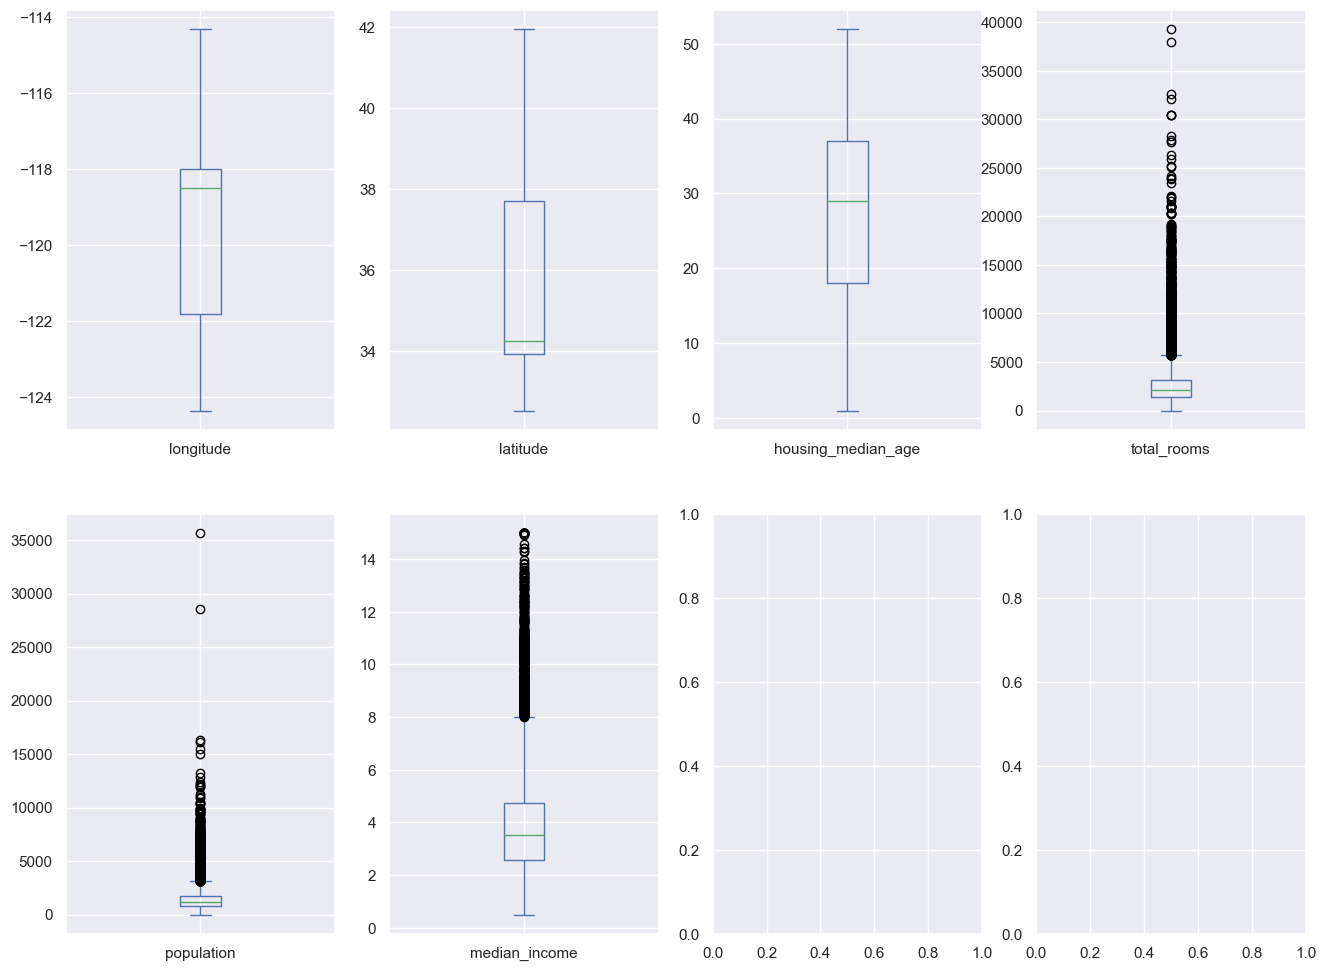

In [13]:
# Plot the distrubution of all numerical columns using boxplot (except the target):
fig, axs = plt.subplots(2, (len(num_cols) // 2) + 1, figsize=(16, 12))
axs = axs.flatten()
for col, ax in zip(num_cols, axs):
    cal_housing_prices[col].plot.box(ax=ax)

## Step #02: Splitting the Data into Training and Testing Sets

In [14]:
# Split the data into feature matrix and target vector:
X = cal_housing_prices.drop(target_col, axis=1)
y = cal_housing_prices[target_col]

In [15]:
# Split the data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Step #03: Chaining the Steps of Data Preprocessing into a Pipeline 

In [16]:
# Create a log-transformer:
log_transformer_cols = [c for c in num_cols if c != "housing_median_age"]
log_transformer = FunctionTransformer(lambda x: np.log(abs(x)))

In [17]:
# Create a numerical features sclaer:
robust_scaler_cols = num_cols[:]
robust_scaler = RobustScaler()

In [18]:
# Create a categorical features encoder:
one_hot_encoder_cols = cat_cols[:]
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

In [19]:
# Create a column transformer:
transformer = ColumnTransformer(
    transformers=[
        ("log_transformer", log_transformer, log_transformer_cols),
        ("robust_scaler", robust_scaler, robust_scaler_cols),
        ("one_hot_encoder", one_hot_encoder, one_hot_encoder_cols)
    ],
    remainder="passthrough"
)

In [20]:
# Fit and transform X_train:
X_train_transformed = transformer.fit_transform(X_train)

In [21]:
# Transform X_test:
X_test_transformed = transformer.transform(X_test)

In [22]:
# Explore the min, mean & max of X_test_transformed:
summary_stats = np.array([
    X_train_transformed.min(axis=0),
    X_train_transformed.mean(axis=0),
    X_train_transformed.max(axis=0)
])

summary_stats = pd.DataFrame(data=summary_stats, index=["min", "mean", "max"])
summary_stats

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
min,4.738914,3.483085,0.693147,1.098612,-0.693347,-1.539474,-0.449735,-1.473684,-1.250292,-1.231257,-1.398664,0.000000,0.000000,0.000000,0.000000
mean,4.783876,3.571904,7.634106,7.028312,1.246010,-0.285183,0.367008,-0.024338,0.302677,0.280524,0.156380,0.444268,0.316528,0.112911,0.126293
max,4.823100,3.736478,10.579489,10.482402,2.708057,1.102632,2.034392,1.210526,21.742690,36.444562,5.283456,1.000000,1.000000,1.000000,1.000000


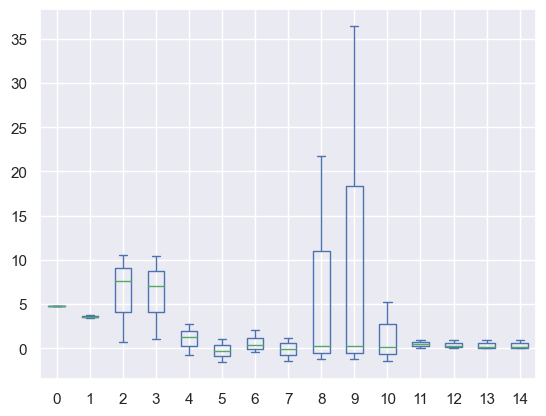

In [23]:
# Plot the distribution of X_test_transformed:
summary_stats.plot.box();

## Step #04: Saving Results

In [24]:
# Create a dictionary to hold the results:
preprocessing_results = {
    "X_train_transformed": X_train_transformed,
    "X_test_transformed": X_test_transformed,
    "y_train": y_train,
    "y_test": y_test
}

In [25]:
# Pickle the results:
with open("./assets/preprocessing_results.pkl", mode="wb") as file_bin:
    pickle.dump(preprocessing_results, file_bin)